In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import matplotlib.cm as cm
    
import sys 
sys.path.insert(0, '../src/')

from astropy.table import Table
#import galhalo
import anaclass
import os
import warnings; warnings.simplefilter('ignore')


### setting up the SAGA samples

In [2]:
#massmat = anaclass.MassMat("../../data/cross_host/acc_surv_mass.npy")
massmat = anaclass.MassMat("../../data/3000_12_8/acc_surv_mass.npy")
massmat.prep_data()

In [3]:
def cumulative(lgMs_1D):
    """

    Args:
        Ms (numpy): 1D mass array
        mass_bins (numpy): mass bins

    Returns:
        CSMF (numpy): counts in each bin
    """

    mass_bins = np.linspace(4,11,45)

    N = np.histogram(lgMs_1D, bins=mass_bins)[0]
    Nsub = np.sum(N)
    stat = Nsub-np.cumsum(N) 
    return np.insert(stat, 0, Nsub) #to add the missing index

def SHMR(lgMh_2D, alpha=1.85, delta=0.2, sigma=0.2):

    """
    Returns: the log stellar mass array with an added dimension corresponding to the random samples
    """

    M_star_a = 10 # these are the anchor points
    M_halo_a = 11.67

    lgMs_2D = alpha*(lgMh_2D-M_halo_a) - delta*(lgMh_2D-M_halo_a)**2 + M_star_a
    scatter = np.random.normal(loc=0, scale=sigma, size=(lgMs_2D.shape))
    return lgMs_2D + scatter

def find_nearest(values):
    mass_bins = np.linspace(4,11,45)
    indices = np.abs(np.subtract.outer(mass_bins, values)).argmin(0)
    return indices

def MODEL(data):
    
    lgMs_2D = SHMR(data) # will be a 3D array if sigma is non zero
    counts = np.apply_along_axis(cumulative, 1, lgMs_2D)
    quant = np.percentile(counts, np.array([5, 50, 95]), axis=0, method="closest_observation") # median and scatter

    mass_ind = find_nearest([6.5, 7, 7.5])

    Ns = [] # counts from the median value
    Ss = [] # scatter from the 95 and 5 percentiles
    for i in mass_ind:
        Ns.append(quant[1, i])
        Ss.append(quant[2, i] - quant[0,i])

    model = Ns + Ss

    return np.array(model), counts

In [4]:
Nsamp = 100
Nsets = int(massmat.lgMh.shape[0]/Nsamp) #dividing by the number of samples
set_ind = np.arange(0,Nsets)*Nsamp
print("dividing your sample into", Nsets-1, "sets")

real_ind = np.arange(0,Nsets)*100

dividing your sample into 30 sets


In [6]:
set_ind

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
       2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000])

In [7]:
mat = np.zeros(shape=(Nsets-1, 6))
for i in range(Nsets-1):
    mat[i], counts = MODEL(massmat.lgMh[set_ind[i]:set_ind[i+1]])

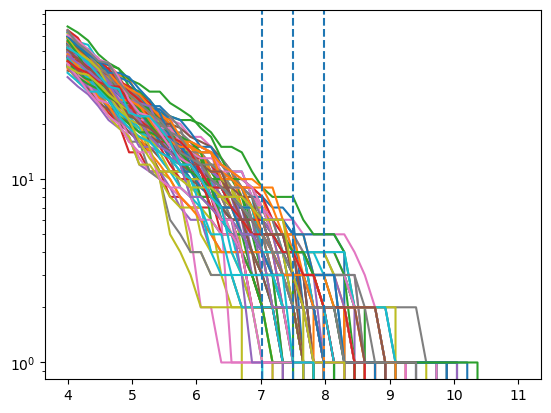

In [58]:
for i in counts:
    plt.plot(np.linspace(4,11,45), i)
plt.axvline(np.linspace(4,11,45)[25], ls="--")
plt.axvline(np.linspace(4,11,45)[19], ls="--")
plt.axvline(np.linspace(4,11,45)[22], ls="--")

plt.yscale("log")
plt.show()

In [59]:
mat.shape
sampave = np.average(mat,axis=0)
sampstd = np.std(mat, axis=0)
covariance = np.cov(mat, rowvar=False)

In [60]:
i = 3 #np.random.randint(mat.shape[0])

real = massmat.lgMh[i*100:i*100+100]

np.save("../../data/3000_12_8/truth_lgMh.npy", real)
np.save("../../data/3000_12_8/covar.npy", covariance)
np.save("../../data/3000_12_8/data.npy", mat[i])
np.save("../../data/3000_12_8/1D_errors.npy", sampstd)

In [61]:
# plt.figure(figsize=(8, 8))
# plt.plot(massmat.mass_bins, tmp_quant[1], color="black")
# plt.fill_between(massmat.mass_bins, y1=tmp_quant[0], y2=tmp_quant[2], color="grey", alpha=0.2)
# plt.scatter(x,10**y, color="red", lw=3, label="fitting points", marker=".")
# plt.ylim(0.5, 10**(2.5))
# plt.plot(xs, ys, color="green", label="scatter")
# plt.plot(massmat.mass_bins, 10**(a*massmat.mass_bins + b), color="blue", ls="--", label="polyfit")
# plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
# plt.ylabel("log N (> m$_{stellar}$)", fontsize=15)
# plt.yscale("log")
# plt.legend(fontsize=12)
# plt.xlim(3.5,10)
# plt.show()

$ (X-X_0)^T C^{-1} (X-X_0) $